# Step 6: Final Evaluation on Test Set

This notebook evaluates the complete multimodal sentiment analysis system on the held-out test set.

**Goal**: Measure the final performance on **completely unseen data** (625 test posts).

**Why This Matters**: The test set has NEVER been seen during training or validation. This gives us an unbiased measure of how well the system will perform on real-world data.

**Process**:
1. Load all four trained models (text, image, video, fusion)
2. Load the test set (625 posts)
3. Extract embeddings from specialist models
4. Run fusion model to get final predictions
5. Compare predictions vs. ground truth
6. Generate comprehensive evaluation report

**Outputs**:
- `results/final_evaluation/confusion_matrix.png`
- `results/final_evaluation/test_metrics.json`
- `results/final_evaluation/test_report.txt`
- `results/final_evaluation/f1_scores_per_class.png`
- `results/final_evaluation/model_comparison.png`

## 1. Setup and Imports

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertModel, CLIPProcessor, CLIPModel
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import json
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Try to import tqdm for notebooks, fallback to regular tqdm
try:
    from tqdm.notebook import tqdm
    print("✓ Using notebook progress bars")
except ImportError:
    from tqdm import tqdm
    print("✓ Using terminal progress bars")

# Set random seeds
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✓ Using notebook progress bars
Using device: cuda
GPU: NVIDIA GeForce RTX 2080 SUPER


## 2. Configuration

In [3]:
# Paths
TEST_DATA = "data/test_set.csv"
MODEL_DIR = "models"
RESULTS_DIR = "results/final_evaluation"

# Create results directory
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

# Model paths
TEXT_MODEL_PATH = f"{MODEL_DIR}/text_specialist_best.pth"
IMAGE_MODEL_PATH = f"{MODEL_DIR}/image_specialist_best.pth"
VIDEO_MODEL_PATH = f"{MODEL_DIR}/video_specialist_best.pth"
FUSION_MODEL_PATH = f"{MODEL_DIR}/fusion_model_best.pth"

# Model parameters
TEXT_MODEL_NAME = 'distilbert-base-uncased'
CLIP_MODEL_NAME = 'openai/clip-vit-base-patch32'
MAX_LENGTH = 128
NUM_FRAMES = 8

# Embedding dimensions
TEXT_EMBED_DIM = 768
IMAGE_EMBED_DIM = 512
VIDEO_EMBED_DIM = 512
TOTAL_EMBED_DIM = TEXT_EMBED_DIM + IMAGE_EMBED_DIM + VIDEO_EMBED_DIM

# Sentiment labels
LABELS = ['Anger', 'Joy', 'Neutral/Other', 'Sadness', 'Surprise']
LABEL_TO_ID = {label: idx for idx, label in enumerate(LABELS)}
ID_TO_LABEL = {idx: label for label, idx in LABEL_TO_ID.items()}

print("Configuration loaded successfully!")

Configuration loaded successfully!


## 3. Define Model Classes

In [4]:
# Text Model
class TextSentimentClassifier(nn.Module):
    def __init__(self, n_classes=5):
        super(TextSentimentClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(TEXT_MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def get_embedding(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
        return pooled_output


# Image Model
class ImageSentimentClassifier(nn.Module):
    def __init__(self, n_classes=5):
        super(ImageSentimentClassifier, self).__init__()
        self.clip = CLIPModel.from_pretrained(CLIP_MODEL_NAME)
        self.vision_embed_dim = self.clip.vision_model.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.vision_embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, n_classes)
        )
        
    def get_embedding(self, pixel_values):
        with torch.no_grad():
            vision_outputs = self.clip.vision_model(pixel_values=pixel_values)
            image_embeds = vision_outputs.pooler_output
        return image_embeds


# Video Model
class VideoSentimentClassifier(nn.Module):
    def __init__(self, n_classes=5, num_frames=8):
        super(VideoSentimentClassifier, self).__init__()
        self.clip = CLIPModel.from_pretrained(CLIP_MODEL_NAME)
        self.num_frames = num_frames
        self.vision_embed_dim = self.clip.vision_model.config.hidden_size
        
        self.temporal_attention = nn.Sequential(
            nn.Linear(self.vision_embed_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.vision_embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, n_classes)
        )
    
    def get_embedding(self, pixel_values):
        with torch.no_grad():
            batch_size, num_frames, C, H, W = pixel_values.shape
            pixel_values = pixel_values.view(batch_size * num_frames, C, H, W)
            
            vision_outputs = self.clip.vision_model(pixel_values=pixel_values)
            frame_embeds = vision_outputs.pooler_output
            frame_embeds = frame_embeds.view(batch_size, num_frames, -1)
            
            attention_scores = self.temporal_attention(frame_embeds)
            attention_weights = torch.softmax(attention_scores, dim=1)
            video_embed = torch.sum(frame_embeds * attention_weights, dim=1)
        
        return video_embed


# Fusion Model
class FusionModel(nn.Module):
    def __init__(self, input_dim, n_classes=5):
        super(FusionModel, self).__init__()
        
        self.fusion = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, n_classes)
        )
    
    def forward(self, x):
        return self.fusion(x)

print("✓ Model classes defined")

✓ Model classes defined


## 4. Load All Trained Models

In [5]:
print("Loading all trained models...")
print("=" * 80)

# Text model
text_model = TextSentimentClassifier(n_classes=len(LABELS))
text_model.load_state_dict(torch.load(TEXT_MODEL_PATH, map_location=device))
text_model = text_model.to(device)
text_model.eval()
print(f"✓ Text model loaded from {TEXT_MODEL_PATH}")

# Image model
image_model = ImageSentimentClassifier(n_classes=len(LABELS))
image_model.load_state_dict(torch.load(IMAGE_MODEL_PATH, map_location=device))
image_model = image_model.to(device)
image_model.eval()
print(f"✓ Image model loaded from {IMAGE_MODEL_PATH}")

# Video model
video_model = VideoSentimentClassifier(n_classes=len(LABELS), num_frames=NUM_FRAMES)
video_model.load_state_dict(torch.load(VIDEO_MODEL_PATH, map_location=device))
video_model = video_model.to(device)
video_model.eval()
print(f"✓ Video model loaded from {VIDEO_MODEL_PATH}")

# Fusion model
fusion_model = FusionModel(input_dim=TOTAL_EMBED_DIM, n_classes=len(LABELS))
fusion_model.load_state_dict(torch.load(FUSION_MODEL_PATH, map_location=device))
fusion_model = fusion_model.to(device)
fusion_model.eval()
print(f"✓ Fusion model loaded from {FUSION_MODEL_PATH}")

# Load processors
tokenizer = DistilBertTokenizer.from_pretrained(TEXT_MODEL_NAME)
clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)
print("✓ Processors loaded")

print("=" * 80)
print("All models loaded successfully!\n")

Loading all trained models...
✓ Text model loaded from models/text_specialist_best.pth
✓ Image model loaded from models/image_specialist_best.pth
✓ Video model loaded from models/video_specialist_best.pth
✓ Fusion model loaded from models/fusion_model_best.pth
✓ Processors loaded
All models loaded successfully!



## 5. Helper Functions

In [6]:
def extract_frames(video_path, num_frames=8):
    """Extract evenly spaced frames from a video."""
    try:
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if total_frames == 0:
            cap.release()
            return None
        
        frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
        frames = []
        
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(frame_rgb)
                frames.append(pil_image)
        
        cap.release()
        
        if len(frames) < num_frames:
            while len(frames) < num_frames:
                frames.append(frames[-1] if frames else Image.new('RGB', (224, 224), color='black'))
        
        return frames[:num_frames]
    except:
        return None

print("✓ Helper functions defined")

✓ Helper functions defined


## 6. Load Test Set and Extract Embeddings

In [7]:
# Load test set
print("Loading test set...")
test_df = pd.read_csv(TEST_DATA)
print(f"✓ Test set loaded: {len(test_df):,} samples")

print("\nTest set sentiment distribution:")
print(test_df['post_sentiment'].value_counts())

Loading test set...
✓ Test set loaded: 625 samples

Test set sentiment distribution:
post_sentiment
Neutral/Other    198
Joy              182
Anger            166
Surprise          46
Sadness           33
Name: count, dtype: int64


In [8]:
# Extract embeddings from test set
print("\n" + "="*80)
print("EXTRACTING TEST SET EMBEDDINGS")
print("="*80)

test_text_embeds = []
test_image_embeds = []
test_video_embeds = []
test_labels = []

for idx in tqdm(range(len(test_df)), desc="Processing test posts"):
    row = test_df.iloc[idx]
    
    # TEXT EMBEDDING
    title = str(row['title']) if pd.notna(row['title']) else ""
    text = str(row['text']) if pd.notna(row['text']) else ""
    combined_text = f"{title} {text}".strip()
    
    encoding = tokenizer(combined_text, max_length=MAX_LENGTH, padding='max_length',
                        truncation=True, return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    text_embed = text_model.get_embedding(input_ids, attention_mask).squeeze().cpu().numpy()
    
    if text_embed.shape[0] != TEXT_EMBED_DIM:
        text_embed = text_embed.flatten()[:TEXT_EMBED_DIM]
        if len(text_embed) < TEXT_EMBED_DIM:
            text_embed = np.pad(text_embed, (0, TEXT_EMBED_DIM - len(text_embed)))
    test_text_embeds.append(text_embed)
    
    # IMAGE EMBEDDING
    if row['media_type'] == 'image':
        image_path = str(row['local_media_path']).replace('\\', '/')
        try:
            image = Image.open(image_path).convert('RGB')
            inputs = clip_processor(images=image, return_tensors="pt")
            pixel_values = inputs['pixel_values'].to(device)
            image_embed = image_model.get_embedding(pixel_values).squeeze().cpu().numpy()
            
            if image_embed.shape[0] != IMAGE_EMBED_DIM:
                image_embed = image_embed.flatten()[:IMAGE_EMBED_DIM]
                if len(image_embed) < IMAGE_EMBED_DIM:
                    image_embed = np.pad(image_embed, (0, IMAGE_EMBED_DIM - len(image_embed)))
        except:
            image_embed = np.zeros(IMAGE_EMBED_DIM, dtype=np.float32)
    else:
        image_embed = np.zeros(IMAGE_EMBED_DIM, dtype=np.float32)
    
    if image_embed.shape != (IMAGE_EMBED_DIM,):
        image_embed = np.zeros(IMAGE_EMBED_DIM, dtype=np.float32)
    test_image_embeds.append(image_embed)
    
    # VIDEO EMBEDDING
    if row['media_type'] == 'video':
        video_path = str(row['local_media_path']).replace('\\', '/')
        frames = extract_frames(video_path, NUM_FRAMES)
        
        if frames:
            try:
                pixel_values_list = []
                for frame in frames:
                    inputs = clip_processor(images=frame, return_tensors="pt")
                    pixel_values_list.append(inputs['pixel_values'].squeeze(0))
                pixel_values = torch.stack(pixel_values_list).unsqueeze(0).to(device)
                video_embed = video_model.get_embedding(pixel_values).squeeze().cpu().numpy()
                
                if video_embed.shape[0] != VIDEO_EMBED_DIM:
                    video_embed = video_embed.flatten()[:VIDEO_EMBED_DIM]
                    if len(video_embed) < VIDEO_EMBED_DIM:
                        video_embed = np.pad(video_embed, (0, VIDEO_EMBED_DIM - len(video_embed)))
            except:
                video_embed = np.zeros(VIDEO_EMBED_DIM, dtype=np.float32)
        else:
            video_embed = np.zeros(VIDEO_EMBED_DIM, dtype=np.float32)
    else:
        video_embed = np.zeros(VIDEO_EMBED_DIM, dtype=np.float32)
    
    if video_embed.shape != (VIDEO_EMBED_DIM,):
        video_embed = np.zeros(VIDEO_EMBED_DIM, dtype=np.float32)
    test_video_embeds.append(video_embed)
    
    # LABEL
    label = LABEL_TO_ID[row['post_sentiment']]
    test_labels.append(label)

# Convert to arrays
test_text_embeds = np.array(test_text_embeds, dtype=np.float32)
test_image_embeds = np.array(test_image_embeds, dtype=np.float32)
test_video_embeds = np.array(test_video_embeds, dtype=np.float32)
test_labels = np.array(test_labels, dtype=np.int64)

print(f"\n✓ Test embeddings extracted:")
print(f"  Text: {test_text_embeds.shape}")
print(f"  Image: {test_image_embeds.shape}")
print(f"  Video: {test_video_embeds.shape}")
print(f"  Labels: {test_labels.shape}")


EXTRACTING TEST SET EMBEDDINGS


Processing test posts:   0%|          | 0/625 [00:00<?, ?it/s]


✓ Test embeddings extracted:
  Text: (625, 768)
  Image: (625, 512)
  Video: (625, 512)
  Labels: (625,)


## 7. Run Predictions

In [9]:
# Concatenate embeddings
test_combined_embeds = np.concatenate([test_text_embeds, test_image_embeds, test_video_embeds], axis=1)
print(f"Combined test embeddings shape: {test_combined_embeds.shape}")

# Convert to tensors
test_embeds_tensor = torch.FloatTensor(test_combined_embeds).to(device)

# Run predictions
print("\nRunning predictions on test set...")
with torch.no_grad():
    outputs = fusion_model(test_embeds_tensor)
    _, predictions = torch.max(outputs, dim=1)
    predictions = predictions.cpu().numpy()

print(f"✓ Predictions complete: {len(predictions)} predictions generated")

Combined test embeddings shape: (625, 1792)

Running predictions on test set...
✓ Predictions complete: 625 predictions generated


## 8. Calculate Metrics

In [10]:
# Calculate overall metrics
test_accuracy = accuracy_score(test_labels, predictions)
test_f1 = f1_score(test_labels, predictions, average='weighted')

print("="*80)
print("FINAL TEST SET RESULTS")
print("="*80)
print(f"\nOverall Performance:")
print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Weighted F1 Score: {test_f1:.4f}")

# Classification report
report = classification_report(test_labels, predictions, target_names=LABELS, digits=4)
print("\nDetailed Classification Report:")
print(report)

FINAL TEST SET RESULTS

Overall Performance:
  Accuracy: 0.5936 (59.36%)
  Weighted F1 Score: 0.5818

Detailed Classification Report:
               precision    recall  f1-score   support

        Anger     0.6294    0.6446    0.6369       166
          Joy     0.6049    0.6813    0.6408       182
Neutral/Other     0.6287    0.6414    0.6350       198
      Sadness     0.3750    0.0909    0.1463        33
     Surprise     0.2500    0.2174    0.2326        46

     accuracy                         0.5936       625
    macro avg     0.4976    0.4551    0.4583       625
 weighted avg     0.5807    0.5936    0.5818       625



In [11]:
# Per-class metrics
precision, recall, f1_per_class, support = precision_recall_fscore_support(
    test_labels, predictions, labels=range(len(LABELS))
)

print("\nPer-Class Performance:")
print(f"{'Sentiment':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 65)
for idx, label in enumerate(LABELS):
    print(f"{label:<15} {precision[idx]:<10.4f} {recall[idx]:<10.4f} {f1_per_class[idx]:<10.4f} {support[idx]:<10}")


Per-Class Performance:
Sentiment       Precision  Recall     F1-Score   Support   
-----------------------------------------------------------------
Anger           0.6294     0.6446     0.6369     166       
Joy             0.6049     0.6813     0.6408     182       
Neutral/Other   0.6287     0.6414     0.6350     198       
Sadness         0.3750     0.0909     0.1463     33        
Surprise        0.2500     0.2174     0.2326     46        


## 9. Save Results

In [12]:
# Save detailed metrics JSON
test_metrics = {
    "overall": {
        "accuracy": float(test_accuracy),
        "weighted_f1": float(test_f1),
        "test_samples": int(len(test_labels))
    },
    "per_class": {}
}

for idx, label in enumerate(LABELS):
    test_metrics["per_class"][label] = {
        "precision": float(precision[idx]),
        "recall": float(recall[idx]),
        "f1_score": float(f1_per_class[idx]),
        "support": int(support[idx])
    }

with open(f"{RESULTS_DIR}/test_metrics.json", 'w') as f:
    json.dump(test_metrics, f, indent=2)
print(f"✓ Test metrics saved to {RESULTS_DIR}/test_metrics.json")

# Save text report
with open(f"{RESULTS_DIR}/test_report.txt", 'w') as f:
    f.write("FINAL TEST SET EVALUATION REPORT\n")
    f.write("=" * 80 + "\n\n")
    f.write("Multimodal Sentiment Analysis System\n")
    f.write("Brawl Stars Reddit Posts\n\n")
    f.write(f"Test Set Size: {len(test_labels)} samples\n")
    f.write(f"Overall Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)\n")
    f.write(f"Weighted F1 Score: {test_f1:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)
print(f"✓ Test report saved to {RESULTS_DIR}/test_report.txt")

✓ Test metrics saved to results/final_evaluation/test_metrics.json
✓ Test report saved to results/final_evaluation/test_report.txt


## 10. Visualizations

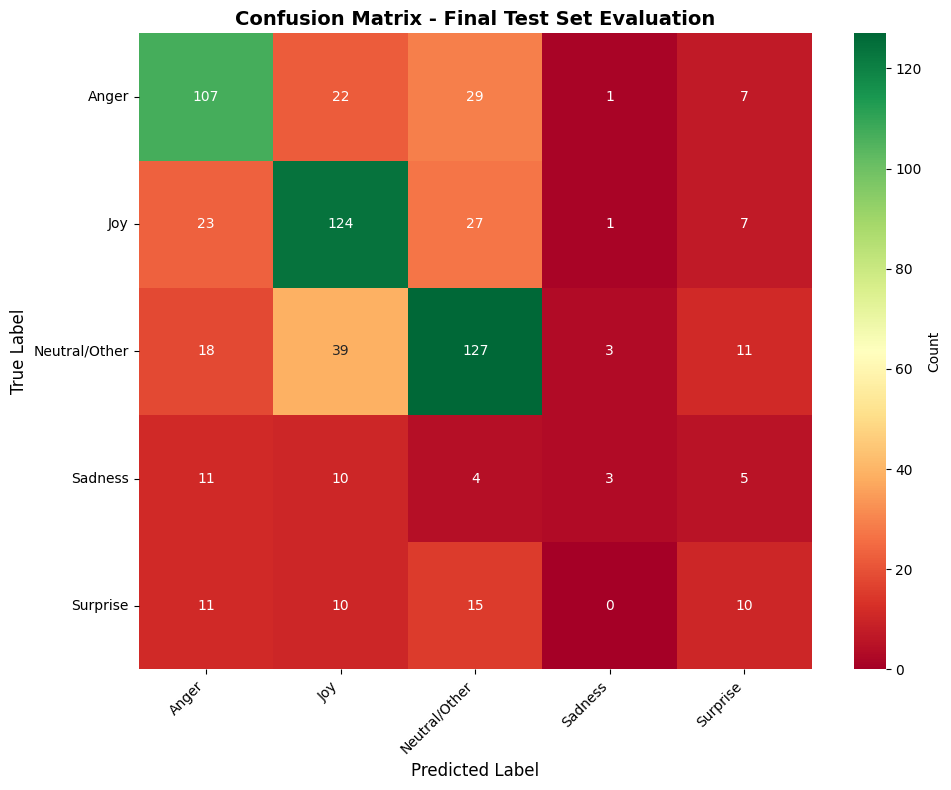

✓ Confusion matrix saved to results/final_evaluation/confusion_matrix.png


In [13]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='RdYlGn',
    xticklabels=LABELS,
    yticklabels=LABELS,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Final Test Set Evaluation', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix saved to {RESULTS_DIR}/confusion_matrix.png")

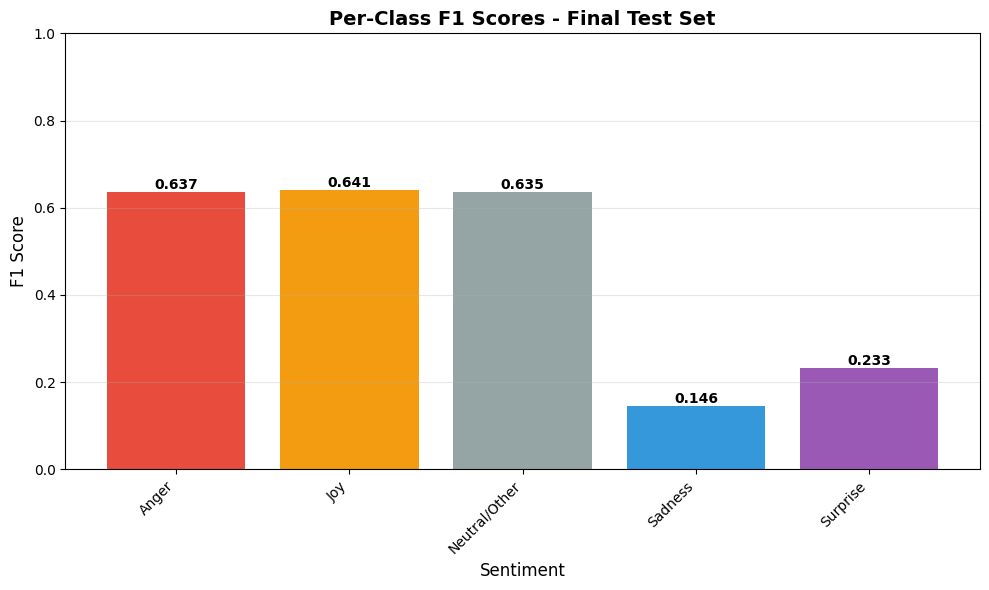

✓ F1 scores plot saved to results/final_evaluation/f1_scores_per_class.png


In [14]:
# Per-class F1 scores
plt.figure(figsize=(10, 6))
bars = plt.bar(LABELS, f1_per_class, color=['#e74c3c', '#f39c12', '#95a5a6', '#3498db', '#9b59b6'])
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Per-Class F1 Scores - Final Test Set', fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, score in zip(bars, f1_per_class):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.3f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/f1_scores_per_class.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ F1 scores plot saved to {RESULTS_DIR}/f1_scores_per_class.png")

## 11. Summary

In [15]:
print("="*80)
print("FINAL EVALUATION COMPLETE!")
print("="*80)
print("\nFiles Generated:")
print(f"  1. Test metrics: {RESULTS_DIR}/test_metrics.json")
print(f"  2. Test report: {RESULTS_DIR}/test_report.txt")
print(f"  3. Confusion matrix: {RESULTS_DIR}/confusion_matrix.png")
print(f"  4. F1 scores: {RESULTS_DIR}/f1_scores_per_class.png")

print("\nFinal Performance Summary:")
print(f"  Test Set Size: {len(test_labels)} posts")
print(f"  Overall Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Weighted F1 Score: {test_f1:.4f}")

print("\nPer-Class F1 Scores:")
for label, f1 in zip(LABELS, f1_per_class):
    print(f"  {label:15s}: {f1:.4f}")

print("\n" + "="*80)
print("MULTIMODAL SENTIMENT ANALYSIS SYSTEM - EVALUATION COMPLETE!")
print("="*80)
print("\nNext Step: Use the system for predictions on new data (Step 7)")
print("="*80)

FINAL EVALUATION COMPLETE!

Files Generated:
  1. Test metrics: results/final_evaluation/test_metrics.json
  2. Test report: results/final_evaluation/test_report.txt
  3. Confusion matrix: results/final_evaluation/confusion_matrix.png
  4. F1 scores: results/final_evaluation/f1_scores_per_class.png

Final Performance Summary:
  Test Set Size: 625 posts
  Overall Accuracy: 0.5936 (59.36%)
  Weighted F1 Score: 0.5818

Per-Class F1 Scores:
  Anger          : 0.6369
  Joy            : 0.6408
  Neutral/Other  : 0.6350
  Sadness        : 0.1463
  Surprise       : 0.2326

MULTIMODAL SENTIMENT ANALYSIS SYSTEM - EVALUATION COMPLETE!

Next Step: Use the system for predictions on new data (Step 7)
